<a href="https://www.kaggle.com/code/suehuynh/kaggle-s4e8-xgboost-binary-class-prediction?scriptVersionId=194806798" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Overview**

Welcome to the 2024 Kaggle Playground Series! We plan to continue in the spirit of previous playgrounds, providing interesting an approachable datasets for our community to practice their machine learning skills, and anticipate a competition each month.

**Your Goal:** The goal of this competition is to predict whether a mushroom is edible or poisonous based on its physical characteristics.

# Preparation

In [73]:
import numpy as np 
import pandas as pd 
import os
import matplotlib                # For plotting and visualization
import matplotlib.pyplot as plt  
from pandas.plotting import parallel_coordinates
import seaborn as sns            # For statistical data visualization
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [74]:
# For machine learning

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, roc_auc_score, median_absolute_error, matthews_corrcoef,
                             f1_score, confusion_matrix, classification_report)
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier

from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Dropout,Input,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import optuna

In [75]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv')
df_train.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [76]:
df_test = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv')
df_test.head()

,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,...,b,NaN,w,u,w,t,g,NaN,d,a
1,3116946,6.90,o,t,o,f,NaN,c,y,1.27,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
2,3116947,2.00,b,g,n,f,NaN,c,n,6.18,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s
3,3116948,3.47,x,t,n,f,s,c,n,4.98,...,NaN,NaN,w,NaN,n,t,z,NaN,d,u
4,3116949,6.17,x,h,y,f,p,NaN,y,6.73,...,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u


# Exploratory Data Analysis

In [77]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [78]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2077964 entries, 0 to 2077963
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), int64(1), object(17)
memory usage: 332.9+ MB


In [79]:
df_train.describe().T.style

,count,mean,std,min,25%,50%,75%,max
id,3116945.000000,1558472.000000,899784.661737,0.000000,779236.000000,1558472.000000,2337708.000000,3116944.000000
cap-diameter,3116941.000000,6.309848,4.657931,0.030000,3.320000,5.750000,8.240000,80.670000
stem-height,3116945.000000,6.348333,2.699755,0.000000,4.670000,5.880000,7.410000,88.720000
stem-width,3116945.000000,11.153785,8.095477,0.000000,4.970000,9.650000,15.630000,102.900000


In [80]:
df_train.describe(include='all').T.style

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,3116945.000000,nan,nan,nan,1558472.000000,899784.661737,0.000000,779236.000000,1558472.000000,2337708.000000,3116944.000000
class,3116945,2,p,1705396,nan,nan,nan,nan,nan,nan,nan
cap-diameter,3116941.000000,nan,nan,nan,6.309848,4.657931,0.030000,3.320000,5.750000,8.240000,80.670000
cap-shape,3116905,74,x,1436026,nan,nan,nan,nan,nan,nan,nan
cap-surface,2445922,83,t,460777,nan,nan,nan,nan,nan,nan,nan
cap-color,3116933,78,n,1359542,nan,nan,nan,nan,nan,nan,nan
does-bruise-or-bleed,3116937,26,f,2569743,nan,nan,nan,nan,nan,nan,nan
gill-attachment,2593009,78,a,646034,nan,nan,nan,nan,nan,nan,nan
gill-spacing,1858510,48,c,1331054,nan,nan,nan,nan,nan,nan,nan
gill-color,3116888,63,w,931538,nan,nan,nan,nan,nan,nan,nan


In [81]:
df_test.describe().T.style

,count,mean,std,min,25%,50%,75%,max
id,2077964.000000,4155926.500000,599856.681721,3116945.000000,3636435.750000,4155926.500000,4675417.250000,5194908.000000
cap-diameter,2077957.000000,6.306192,4.685462,0.000000,3.310000,5.740000,8.230000,607.000000
stem-height,2077963.000000,6.346509,2.698978,0.000000,4.670000,5.880000,7.410000,57.290000
stem-width,2077964.000000,11.148374,8.100181,0.000000,4.970000,9.640000,15.620000,102.910000


In [82]:
df_test.describe(include='all').T.style

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,2077964.000000,nan,nan,nan,4155926.500000,599856.681721,3116945.000000,3636435.750000,4155926.500000,4675417.250000,5194908.000000
cap-diameter,2077957.000000,nan,nan,nan,6.306192,4.685462,0.000000,3.310000,5.740000,8.230000,607.000000
cap-shape,2077933,62,x,957949,nan,nan,nan,nan,nan,nan,nan
cap-surface,1631060,59,t,306852,nan,nan,nan,nan,nan,nan,nan
cap-color,2077951,57,n,904307,nan,nan,nan,nan,nan,nan,nan
does-bruise-or-bleed,2077954,22,f,1713662,nan,nan,nan,nan,nan,nan,nan
gill-attachment,1728143,66,a,430960,nan,nan,nan,nan,nan,nan,nan
gill-spacing,1238369,35,c,886976,nan,nan,nan,nan,nan,nan,nan
gill-color,2077915,56,w,620773,nan,nan,nan,nan,nan,nan,nan
stem-height,2077963.000000,nan,nan,nan,6.346509,2.698978,0.000000,4.670000,5.880000,7.410000,57.290000


## Visualization & Statistical Analysis

### Feature Distribution by Class

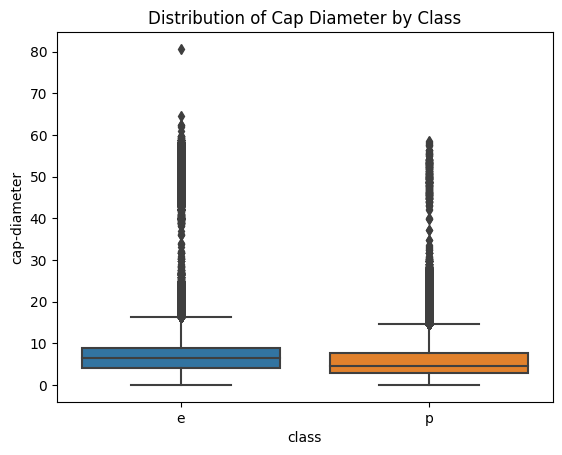

In [83]:
# Boxplot for cap diameter by class
sns.boxplot(x='class', y='cap-diameter', data=df_train)
plt.title('Distribution of Cap Diameter by Class')
plt.show()

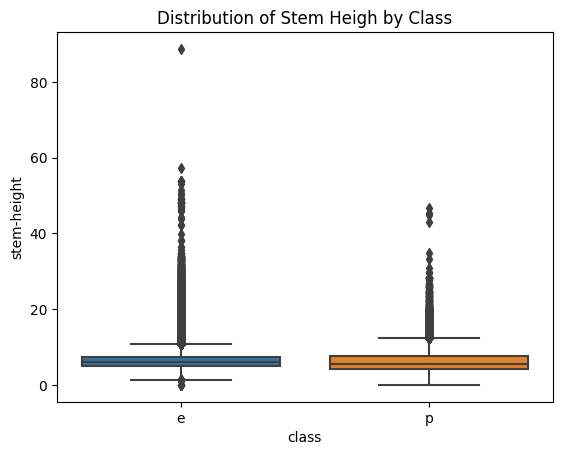

In [84]:
# Boxplot for cap diameter by class
sns.boxplot(x='class', y='stem-height', data=df_train)
plt.title('Distribution of Stem Heigh by Class')
plt.show()

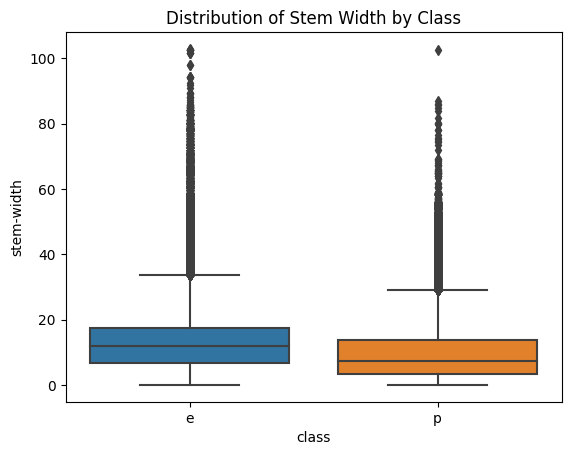

In [85]:
# Boxplot for cap diameter by class
sns.boxplot(x='class', y='stem-width', data=df_train)
plt.title('Distribution of Stem Width by Class')
plt.show()

In [86]:
df_train.columns

Index(['id', 'class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')

In [87]:
for column in df_train.columns:
    n_nulls = df_train[column].isnull().sum() / len(df_train) * 100
    if n_nulls < 50:
        continue
    print('NaN in column', column, 'accounts for', n_nulls, 'percentage of train data')

NaN in column stem-root accounts for 88.45273176138816 percentage of train data
NaN in column stem-surface accounts for 63.55136199066715 percentage of train data
NaN in column veil-type accounts for 94.88434990030302 percentage of train data
NaN in column veil-color accounts for 87.93697033473481 percentage of train data
NaN in column spore-print-color accounts for 91.42548232323637 percentage of train data


In [88]:
for column in df_train.columns:
    print(column, df_train[column].value_counts())

id id
0          1
2077967    1
2077958    1
2077959    1
2077960    1
          ..
1038984    1
1038985    1
1038986    1
1038987    1
3116944    1
Name: count, Length: 3116945, dtype: int64
class class
p    1705396
e    1411549
Name: count, dtype: int64
cap-diameter cap-diameter
1.49     8164
3.18     7942
3.14     7361
1.51     7072
4.04     6828
         ... 
58.19       1
31.59       1
24.93       1
58.76       1
54.07       1
Name: count, Length: 3913, dtype: int64
cap-shape cap-shape
x        1436026
f         676238
s         365146
b         318646
o         108835
          ...   
12.62          1
5.15           1
19.04          1
49.21          1
19.06          1
Name: count, Length: 74, dtype: int64
cap-surface cap-surface
t        460777
s        384970
y        327826
h        284460
g        263729
          ...  
1.42          1
has h         1
10.83         1
8.96          1
0.87          1
Name: count, Length: 83, dtype: int64
cap-color cap-color
n             1359542

**Observations**
- `stem_root`, `stem-surface`, `veil-type`, `veil-color`, `spore-print-color` columns are having more than 90% of values are missing values, showing their low usability for our models. 
- After exploring the value counts of the data columns, we also noticed that data are quite dirty with mixing data type (string and number)

**Actions:**
- Replace messy data types and missing data with modes

## Data Cleaning

### Replace NaN values with mode

In [89]:
for column in df_train.columns:
    mode = df_train[column].mode()[0]
    df_train[column].fillna(mode, inplace=True)
    print(df_train.isnull().sum())
for column in df_test.columns:
    mode = df_test[column].mode()[0]
    df_test[column].fillna(mode, inplace=True)
    print(df_test.isnull().sum())

id                            0
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64
id                            0
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            125

### Replace messy data with mode

In [90]:
for column in df_train.columns:
    # Calculate frequency counts for each value
    value_counts = df_train[column].value_counts()
    # Identify values with frequency lower than 20
    low_frequency_values = value_counts[value_counts < 20].index
    # Calculate the mode of the column
    mode_value = df_train[column].mode()[0]
    # Replace low-frequency values with the mode
    df_train[column] = df_train[column].apply(lambda x: mode_value if x in low_frequency_values else x)

for column in df_test.columns:
    # Calculate frequency counts for each value
    value_counts = df_test[column].value_counts()
    # Identify values with frequency lower than 20
    low_frequency_values = value_counts[value_counts < 20].index
    # Calculate the mode of the column
    mode_value = df_test[column].mode()[0]
    # Replace low-frequency values with the mode
    df_test[column] = df_test[column].apply(lambda x: mode_value if x in low_frequency_values else x)

In [91]:
# def cleaning(df):
#     threshold = 101
#     cat_feat = ["cap-shape", "cap-surface", "cap-color", "does-bruise-or-bleed", "gill-attachment",
#                 "gill-spacing", "gill-color", "stem-root", "stem-surface", "stem-color",
#                 "has-ring", "ring-type", "spore-print-color", "habitat", "season"]
    
#     for i in cat_feat:
#         if df[i].dtype.name == 'category':
#             if 'missing' not in df[i].cat.categories:
#                 df[i] = df[i].cat.add_categories('missing')
#             if 'noise' not in df[i].cat.categories:
#                 df[i] = df[i].cat.add_categories('noise')
#         else:
#             df[i] = df[i].astype('category')
#             df[i] = df[i].cat.add_categories(['missing', 'noise'])
        
#         df[i] = df[i].fillna('missing')
        
#         count = df[i].value_counts(dropna=False)
#         less_freq = count[count < threshold].index
        
#         df[i] = df[i].apply(lambda x: 'noise' if x in less_freq else x)
    
#     return df

In [92]:
for column in df_train.columns:
    print(column, df_train[column].value_counts())

id id
0    3116945
Name: count, dtype: int64
class class
p    1705396
e    1411549
Name: count, dtype: int64
cap-diameter cap-diameter
1.49     17740
3.18      7942
3.14      7361
1.51      7072
4.04      6828
         ...  
51.92       20
23.41       20
46.26       20
17.41       20
47.84       20
Name: count, Length: 2257, dtype: int64
cap-shape cap-shape
x    1436156
f     676238
s     365146
b     318646
o     108835
p     106967
c     104520
d         65
e         60
n         41
w         36
t         36
g         34
y         33
r         32
a         30
u         27
z         22
l         21
Name: count, dtype: int64
cap-surface cap-surface
t    1131899
s     384970
y     327826
h     284460
g     263729
d     206832
k     128875
e     119712
i     113440
w     109840
l      44859
n         96
f         75
p         59
u         49
a         44
m         42
o         39
r         35
x         33
c         31
Name: count, dtype: int64
cap-color cap-color
n    1359691
y     38662

In [93]:
for column in df_test.columns:
    print(column, df_test[column].value_counts())

id id
3116945    2077964
Name: count, dtype: int64
cap-diameter cap-diameter
1.49     14400
3.18      5174
3.14      4956
1.51      4720
3.28      4577
         ...  
20.54       20
22.71       20
22.65       20
22.72       20
55.52       20
Name: count, Length: 2092, dtype: int64
cap-shape cap-shape
x    958124
f    452360
s    242698
b    211879
o     71972
p     71302
c     69436
e        33
d        30
t        28
n        27
w        27
a        24
y        24
Name: count, dtype: int64
cap-surface cap-surface
t    753836
s    257190
y    218336
h    189737
g    176140
d    137675
k     86041
e     79918
i     75570
w     73109
l     30101
f        54
n        50
p        44
o        37
a        28
x        27
r        25
m        25
u        21
Name: count, dtype: int64
cap-color cap-color
n    904447
y    259062
w    253844
g    140681
e    131524
o    119764
p     61186
r     51784
u     48865
b     40790
k     39615
l     26261
f        45
d        40
a        36
s        20
Na

### Distribution of each class by each feature type

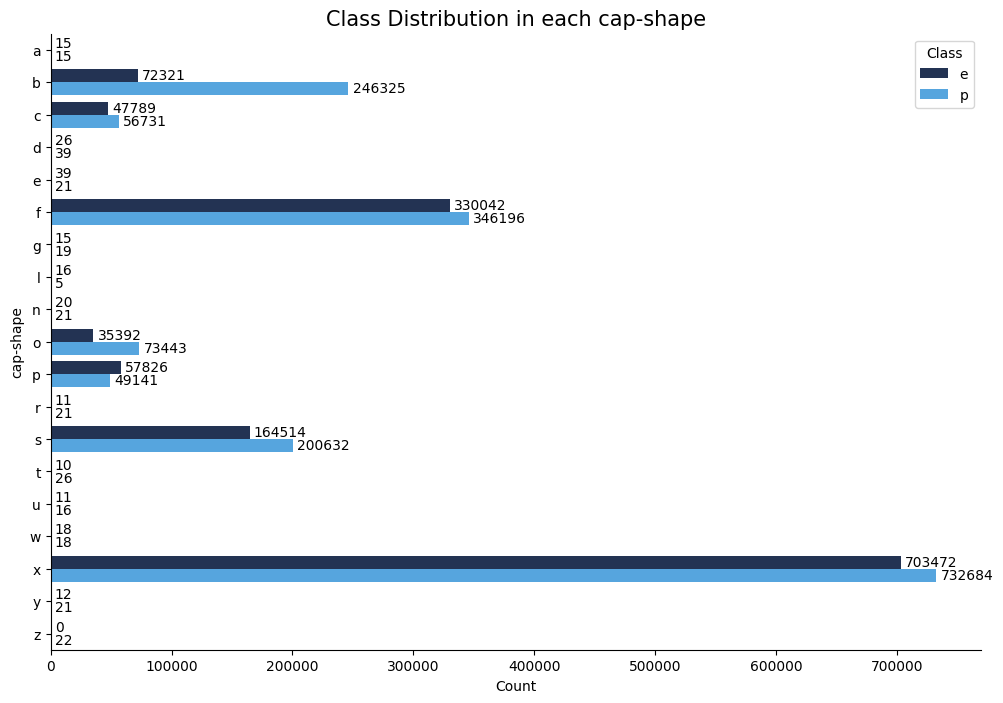

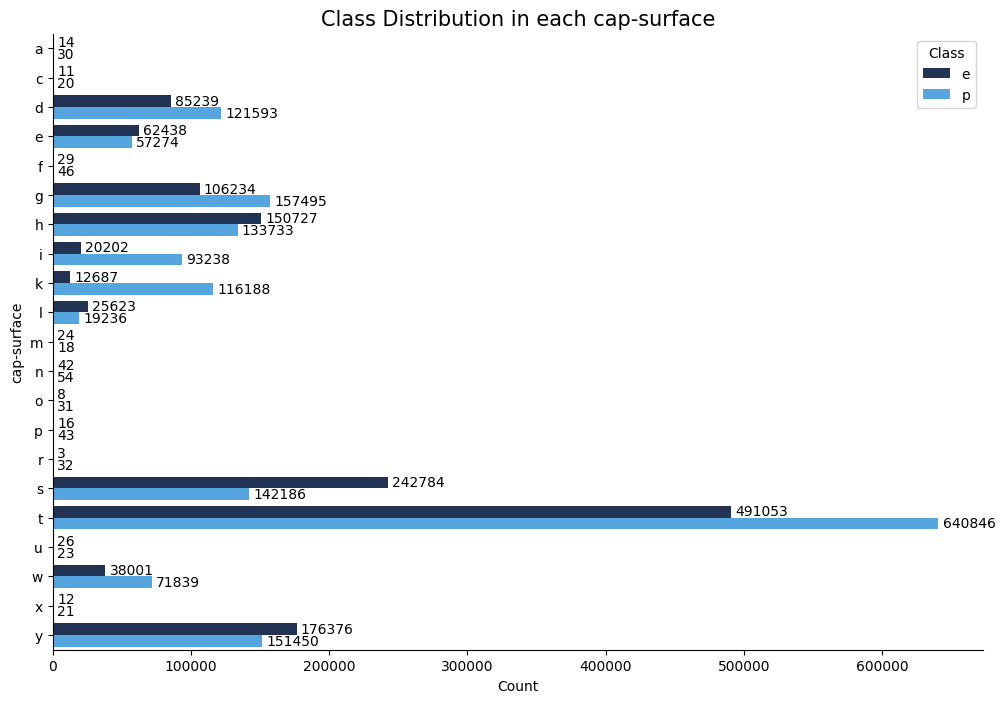

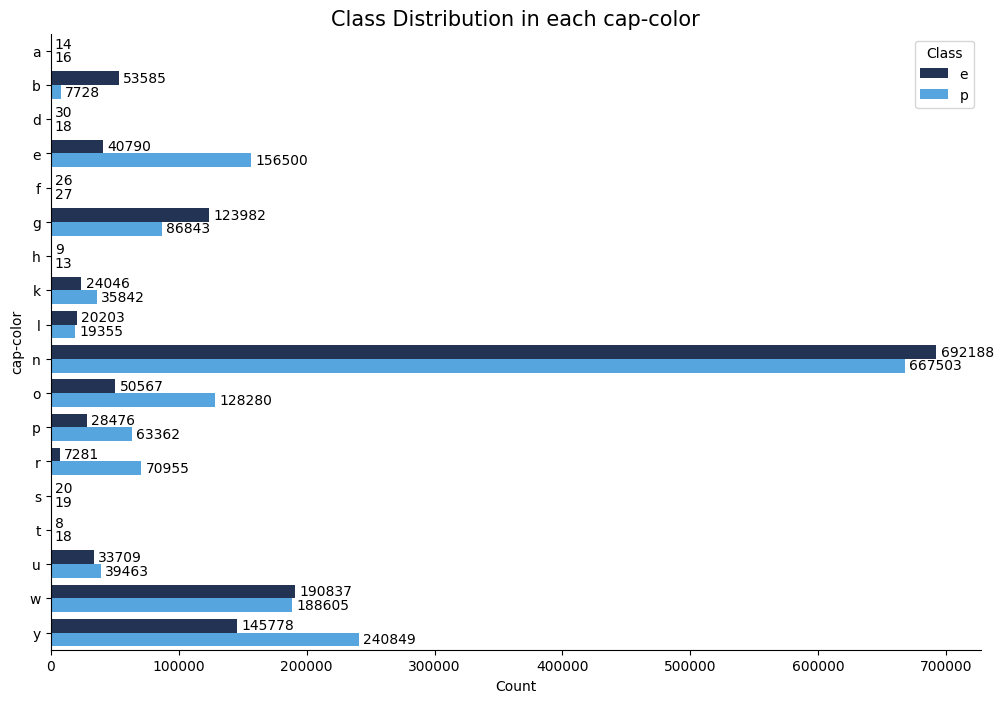

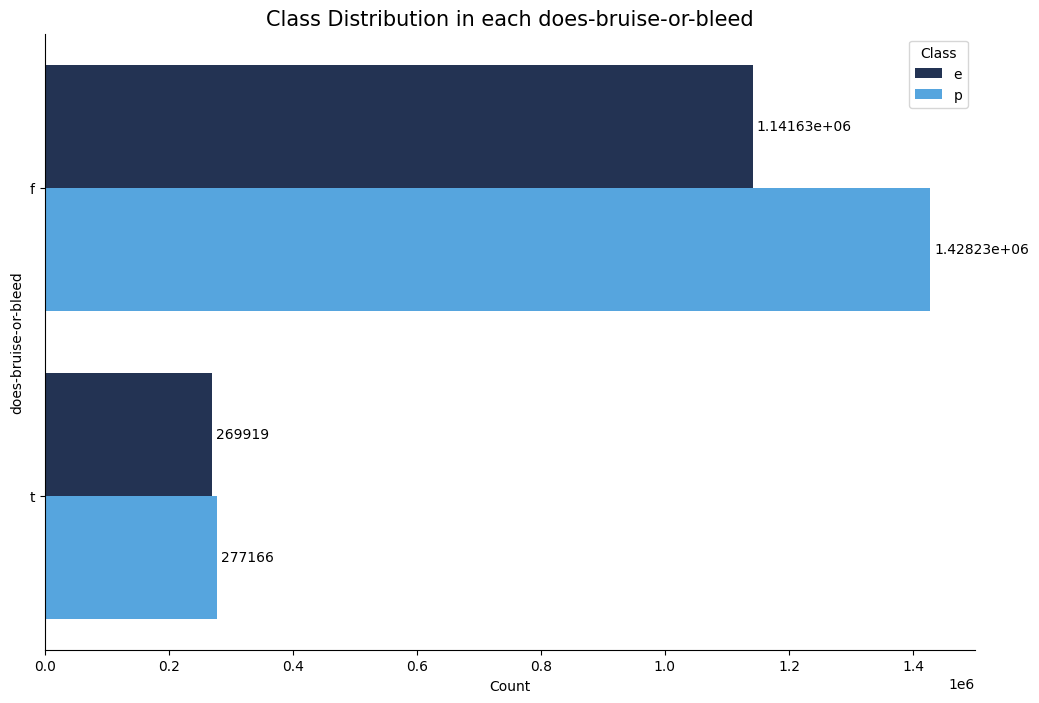

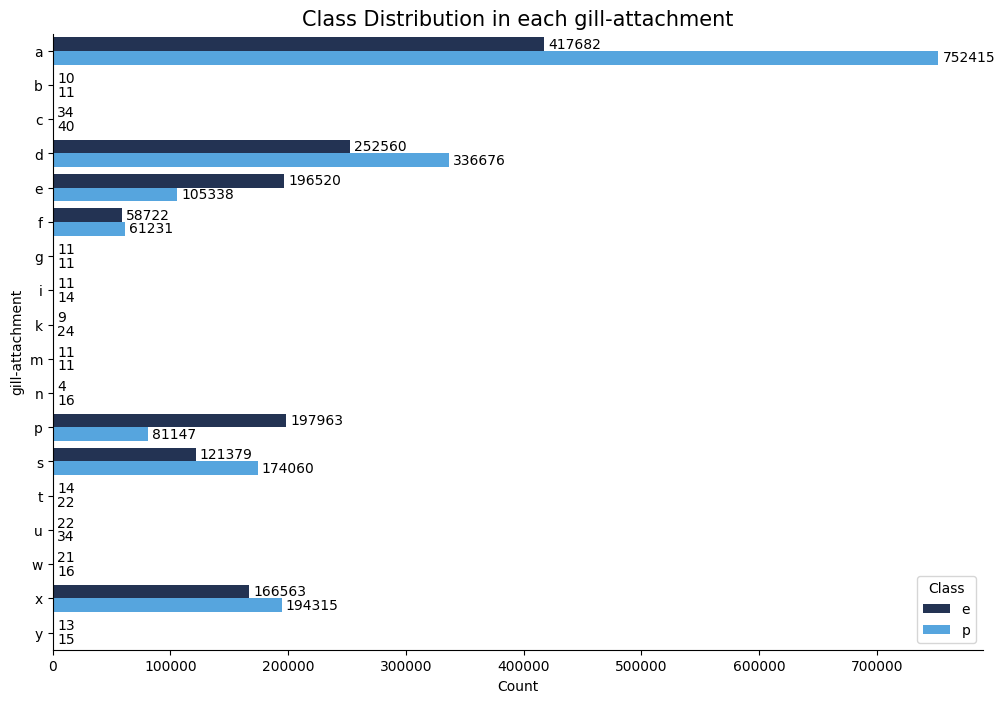

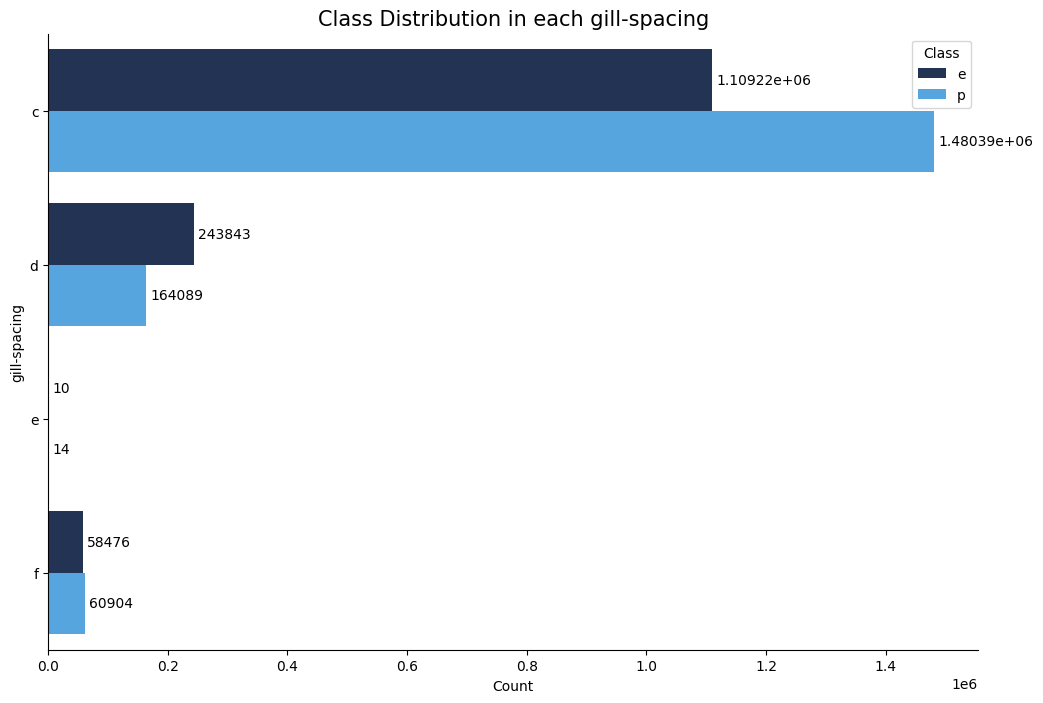

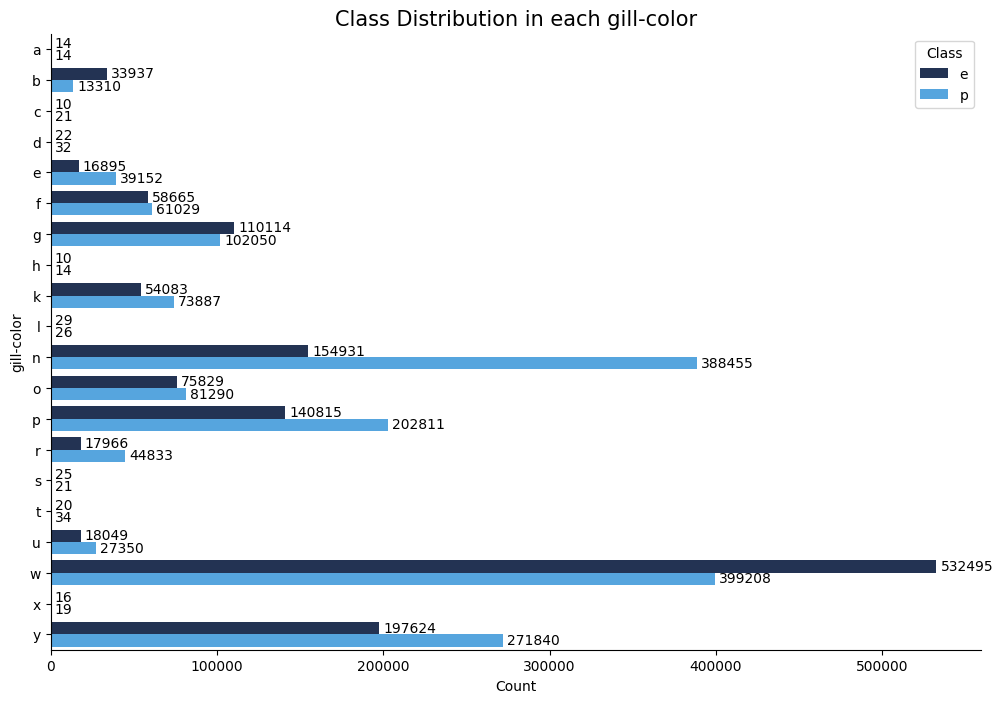

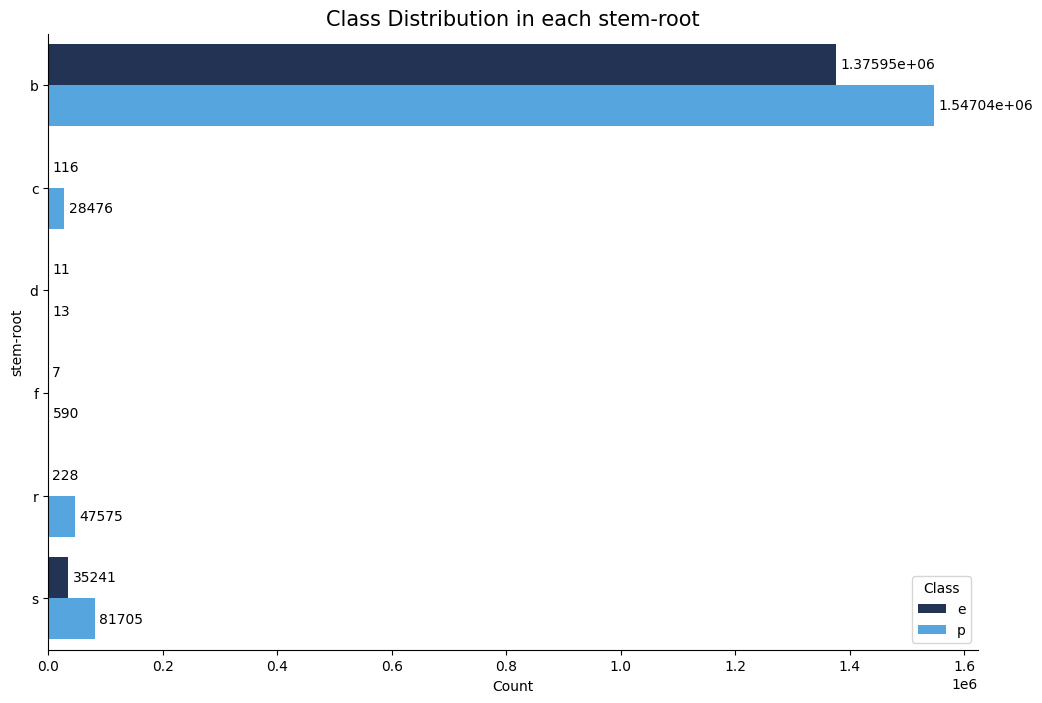

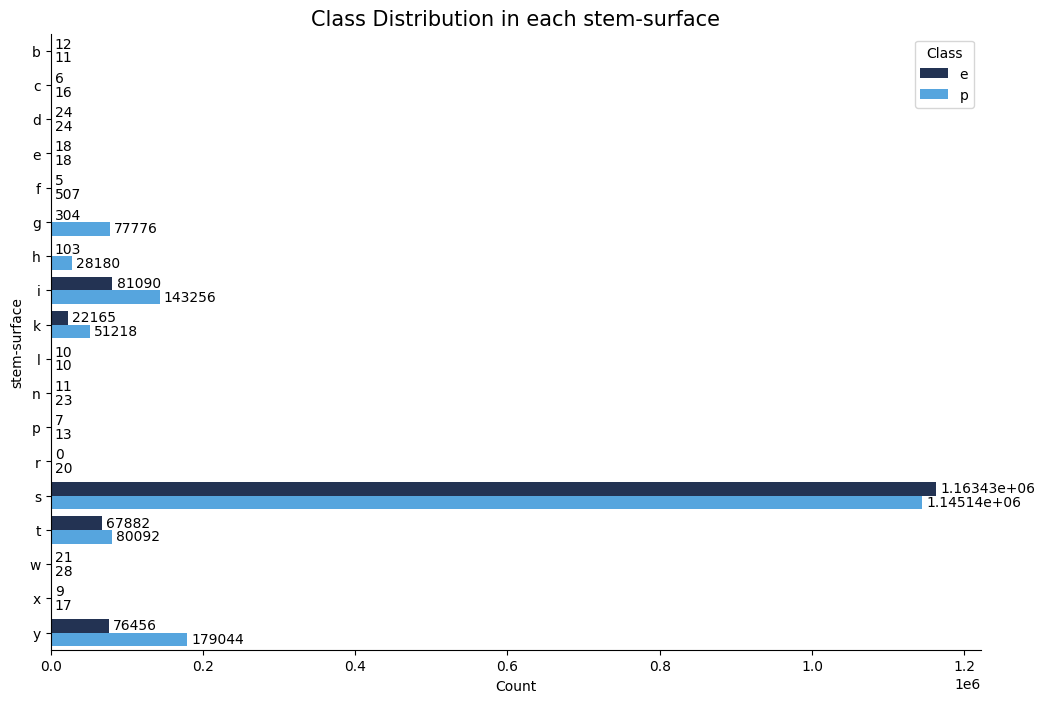

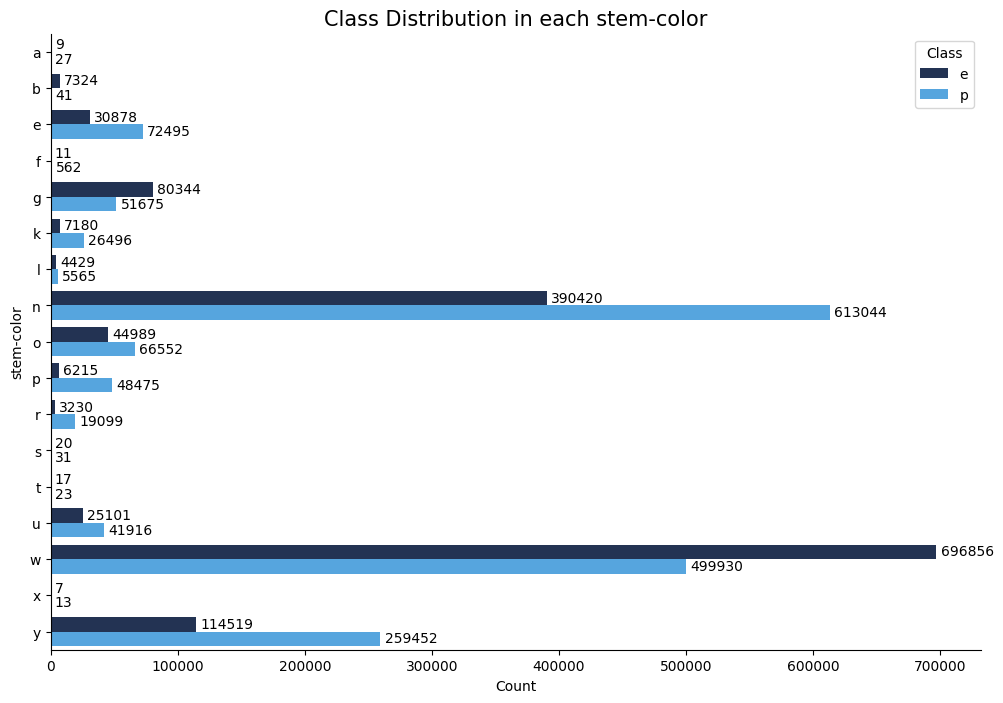

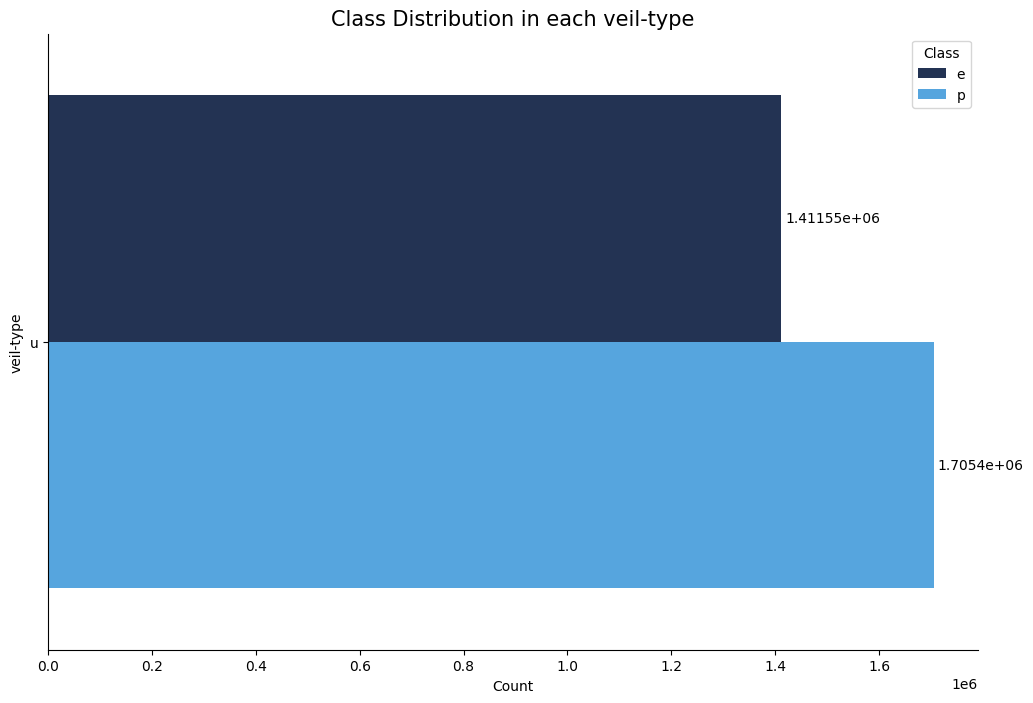

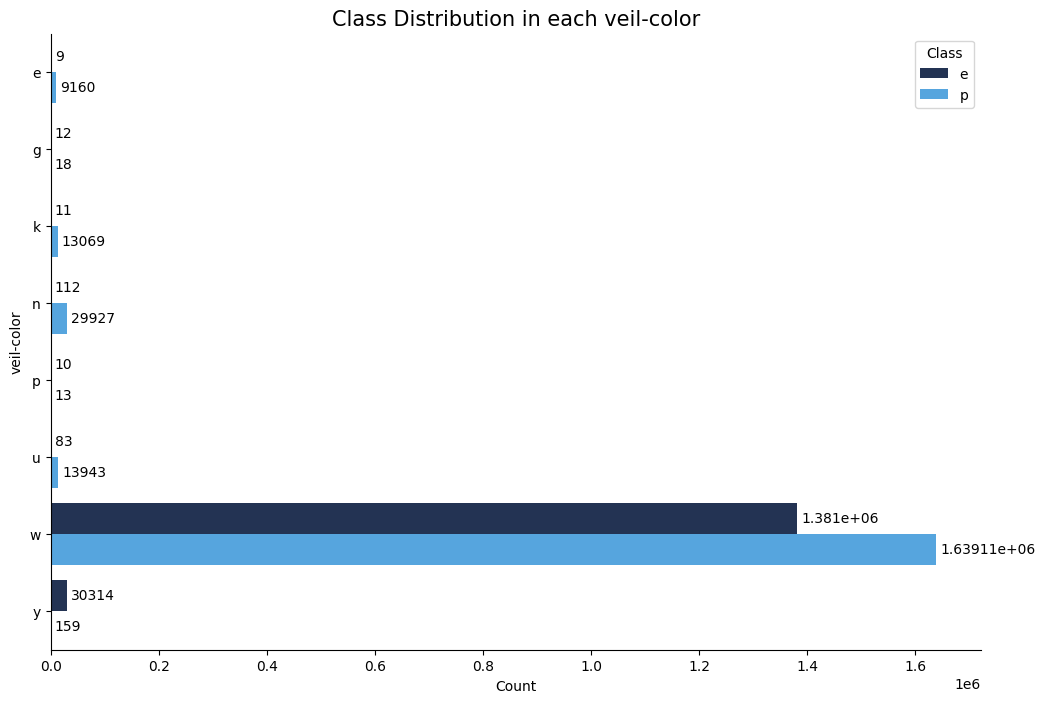

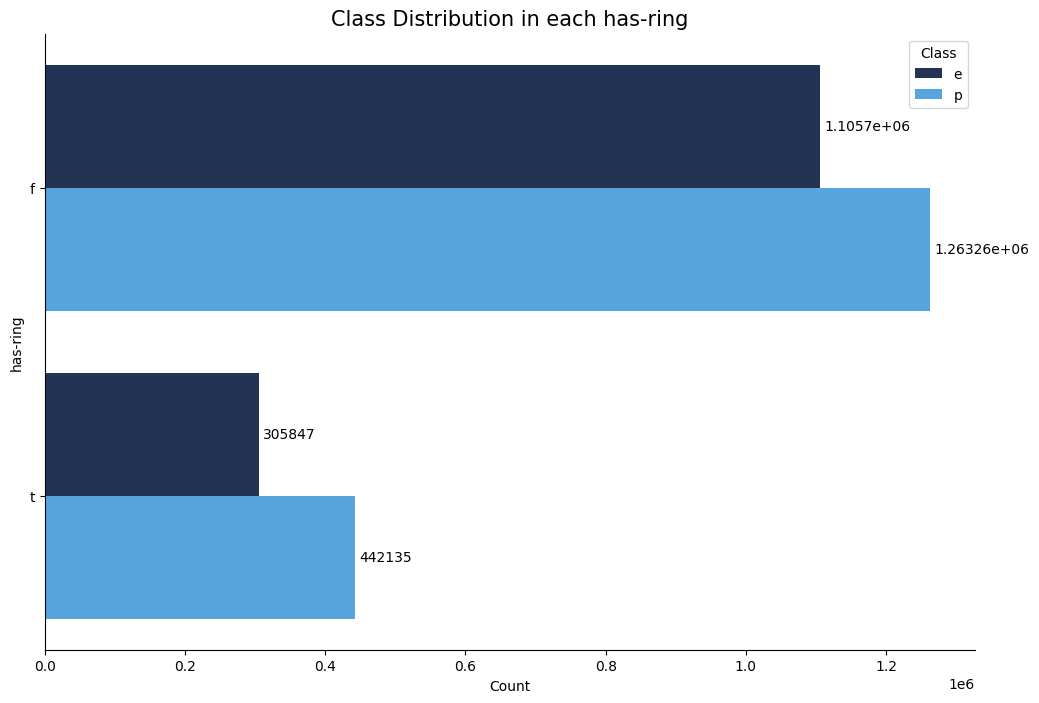

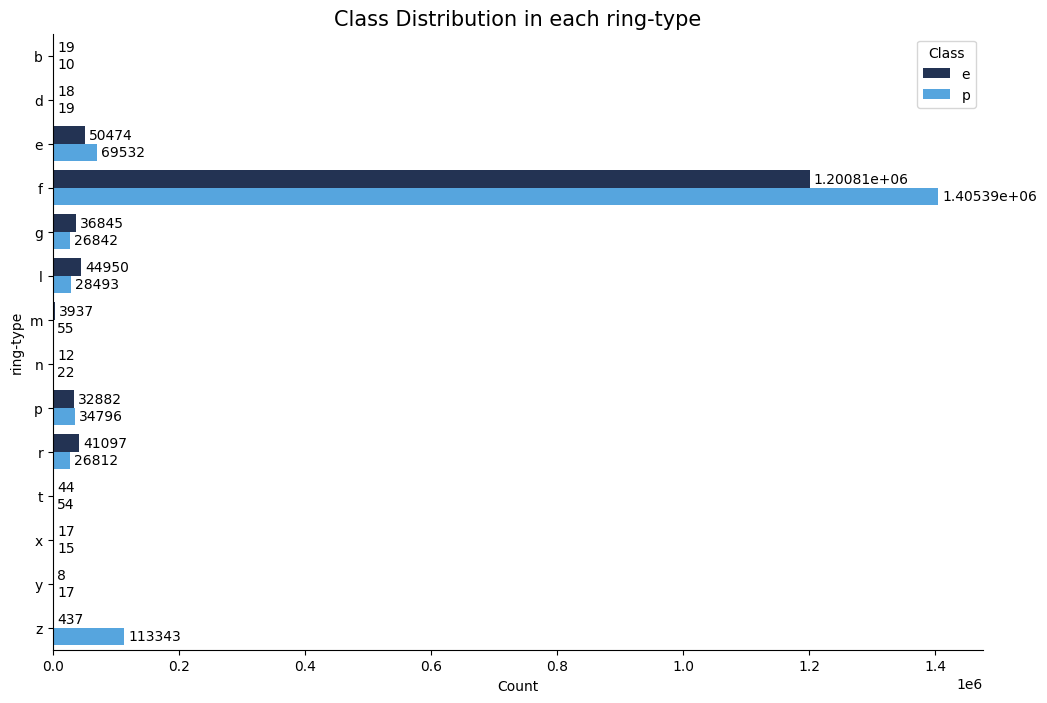

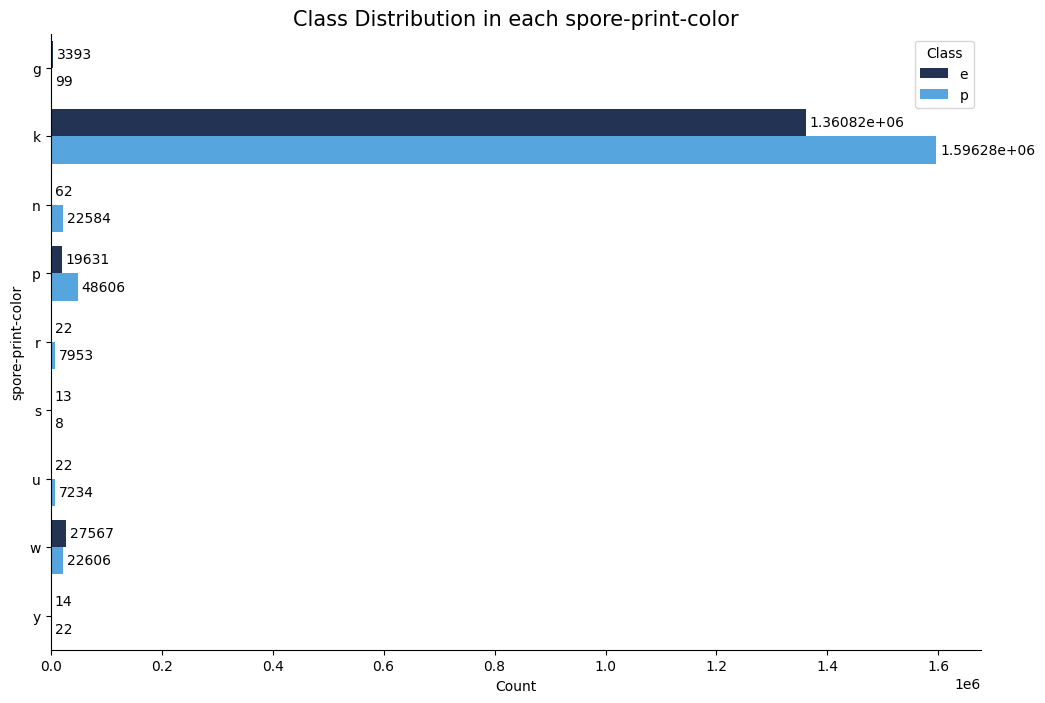

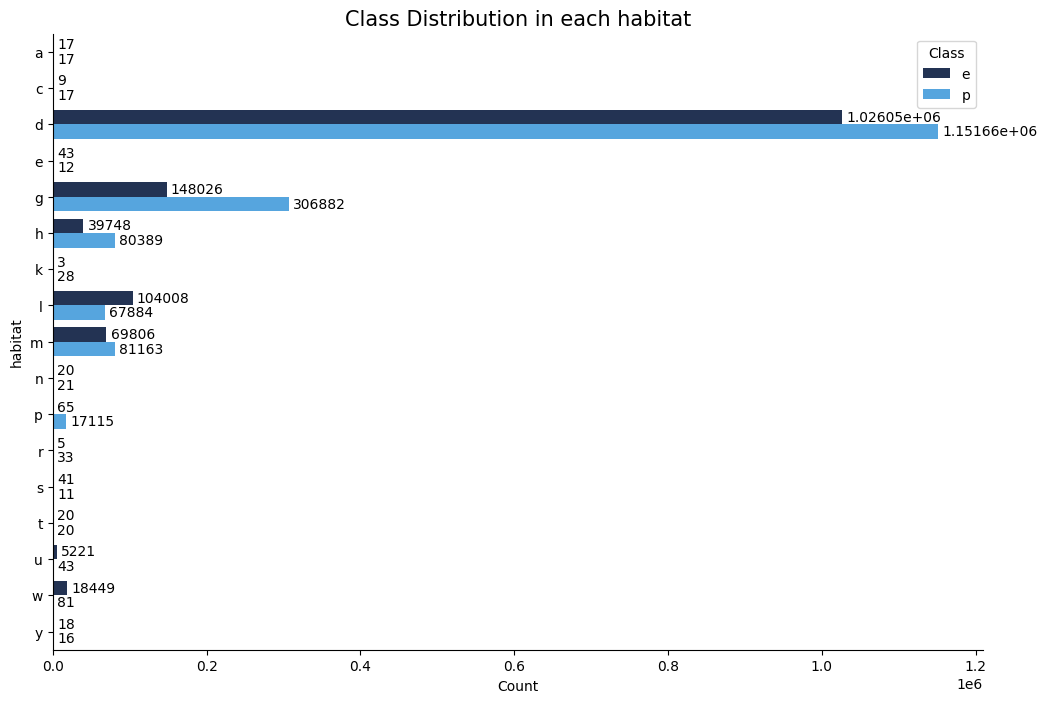

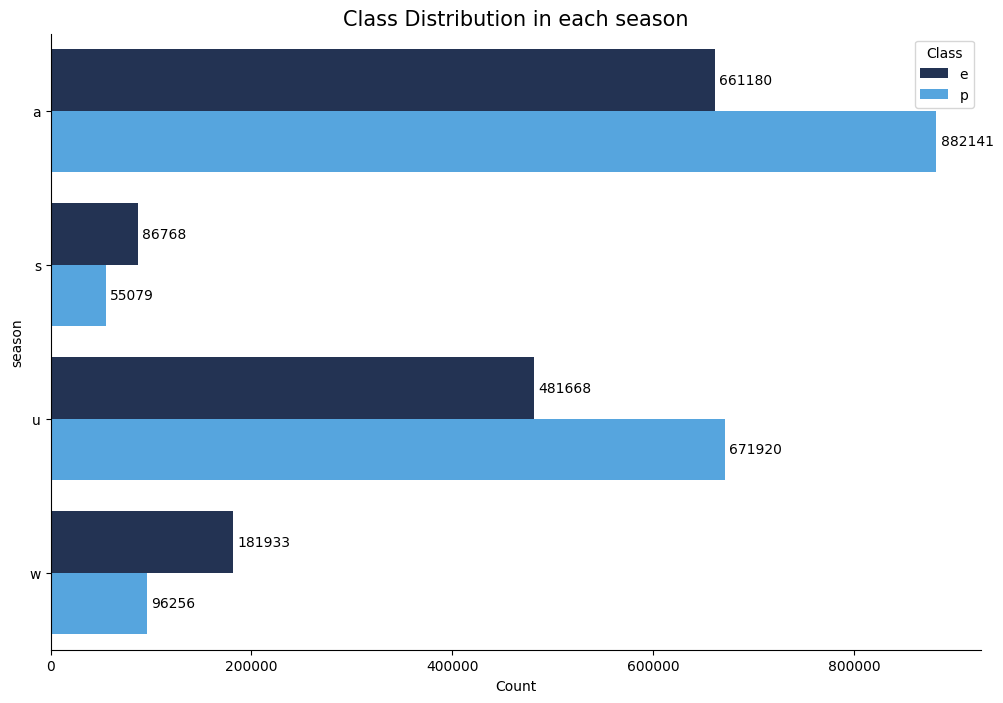

In [94]:
def plot_class_distribution(df, column_name):
    """
    Plots the distribution of 'class' across different values of the specified column.
    """
    # Group by the specified column and 'class', and count occurrences
    count_df = df_train.groupby([column_name, 'class']).size().unstack(fill_value=0)
    count_df.reset_index(inplace=True)

    # Reshape the DataFrame to a long format
    df_long = pd.melt(count_df, id_vars=[column_name], value_vars=df['class'].unique(), 
                      var_name='Class', value_name='Count')

    # Create the bar plot
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.barplot(data=df_long, x='Count', y=column_name, hue='Class', 
                palette=['#1B305B', '#3FA9F5'], ax=ax)

    # Set the main title
    plt.title(f'Class Distribution in each {column_name}', fontsize=15)

    # Add data labels
    for container in ax.containers:
        ax.bar_label(container, padding=3)

    # Remove unnecessary spines
    sns.despine(right=True)

    # Show the plot
    plt.show()

    
for column in df_train.select_dtypes(include='object').columns:
    if column != 'class':
        plot_class_distribution(df_train, column)

# Preprocessing

In [95]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y = le.fit_transform(df_train['class'])
# X = df_train.drop(['class','id'],axis=1)
# train_X, test_X, train_y, test_y = train_test_split(X, y,test_size = 0.2, random_state =42,stratify=y)

In [96]:
df_train = df_train.drop(['id'], axis = 1)
df_test = df_test.drop(['id'], axis = 1)

In [97]:
X = df_train.drop(columns = ['class'] , axis = 1)
y = df_train['class']

## Frequency Encoder

In [98]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.frequency_maps = {}

    def fit(self, X, y=None):
        for column in self.columns:
            frequency = X[column].value_counts()
            self.frequency_maps[column] = frequency
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for column in self.columns:
            X_transformed[column + '_freq'] = X_transformed[column].map(self.frequency_maps[column])
        return X_transformed

In [99]:
# Define columns for frequency encoding
freq_cols = [column for column in df_train.select_dtypes(include='object').columns if column != 'class']

# Define numerical columns
num_cols = [column for column in X.columns if column not in freq_cols]

# Initialize FrequencyEncoder with the specified columns
freq_encoder = FrequencyEncoder(columns=freq_cols)

# Fit the frequency encoder to the data
freq_encoder.fit(X)

# Transform the data to include frequency encoded columns
X_freq_encoded = freq_encoder.transform(X)
df_test_freq_encoded = freq_encoder.transform(df_test)

# Define the preprocessing for numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('freq', 'passthrough', [col + '_freq' for col in freq_cols])
    ])

# Fit and transform the training data
X_processed = preprocessor.fit_transform(X_freq_encoded)
df_test_processed = preprocessor.transform(df_test_freq_encoded)

# Convert processed arrays back to DataFrames
X_processed = pd.DataFrame(X_processed, columns=preprocessor.get_feature_names_out())
df_test_processed = pd.DataFrame(df_test_processed, columns=preprocessor.get_feature_names_out())

# Keep dataframe names consistent
X = X_processed
#df_test = df_test_processed

In [100]:
df_test_processed.head()

,num__cap-diameter,num__stem-height,num__stem-width,freq__cap-shape_freq,freq__cap-surface_freq,freq__cap-color_freq,freq__does-bruise-or-bleed_freq,freq__gill-attachment_freq,freq__gill-spacing_freq,freq__gill-color_freq,freq__stem-root_freq,freq__stem-surface_freq,freq__stem-color_freq,freq__veil-type_freq,freq__veil-color_freq,freq__has-ring_freq,freq__ring-type_freq,freq__spore-print-color_freq,freq__habitat_freq,freq__season_freq
0,0.580909,1.842306,0.777119,1436156.0,1131899.0,1359691.0,547085.0,1170097.0,2589609.0,931703.0,2922983.0,2308569.0,1196786.0,3116945.0,3020105.0,747982.0,63687.0,2957109.0,2177714.0,1543321.0
1,0.167890,-1.934535,-0.034550,108835.0,1131899.0,178847.0,2569860.0,1170097.0,2589609.0,469464.0,2922983.0,2308569.0,1003464.0,3116945.0,3020105.0,2368963.0,2606195.0,2957109.0,2177714.0,1543321.0
2,-0.995211,-0.053776,-1.004220,318646.0,263729.0,1359691.0,2569860.0,1170097.0,2589609.0,543386.0,2922983.0,2308569.0,1003464.0,3116945.0,3020105.0,2368963.0,2606195.0,2957109.0,2177714.0,141847.0
3,-0.646280,-0.513432,-0.319972,1436156.0,1131899.0,1359691.0,2569860.0,295439.0,2589609.0,543386.0,2922983.0,2308569.0,1196786.0,3116945.0,30039.0,747982.0,113780.0,2957109.0,2177714.0,1153588.0
4,-0.005388,0.156900,0.341340,1436156.0,284460.0,386627.0,2569860.0,279110.0,2589609.0,469464.0,2922983.0,2308569.0,373971.0,3116945.0,30473.0,747982.0,2606195.0,2957109.0,2177714.0,1153588.0


## Label Encoder

In [101]:
X_train , X_valid , y_train , y_valid = train_test_split(X , y , test_size = 0.2 , random_state = 42, stratify = y)
X_train.head()

,num__cap-diameter,num__stem-height,num__stem-width,freq__cap-shape_freq,freq__cap-surface_freq,freq__cap-color_freq,freq__does-bruise-or-bleed_freq,freq__gill-attachment_freq,freq__gill-spacing_freq,freq__gill-color_freq,freq__stem-root_freq,freq__stem-surface_freq,freq__stem-color_freq,freq__veil-type_freq,freq__veil-color_freq,freq__has-ring_freq,freq__ring-type_freq,freq__spore-print-color_freq,freq__habitat_freq,freq__season_freq
586767,-0.294977,-0.965427,0.170597,1436156.0,1131899.0,91838.0,2569860.0,1170097.0,2589609.0,931703.0,2922983.0,2308569.0,373971.0,3116945.0,3020105.0,2368963.0,2606195.0,2957109.0,2177714.0,1543321.0
2665706,-1.121015,-0.417670,-1.010591,318646.0,327826.0,1359691.0,2569860.0,1170097.0,2589609.0,127970.0,2922983.0,2308569.0,1196786.0,3116945.0,3020105.0,2368963.0,2606195.0,2957109.0,2177714.0,1153588.0
1270574,0.972566,0.325440,1.216719,1436156.0,119712.0,39558.0,2569860.0,360878.0,2589609.0,931703.0,2922983.0,2308569.0,1196786.0,3116945.0,3020105.0,2368963.0,2606195.0,2957109.0,2177714.0,1543321.0
2935630,0.298442,-0.046115,-0.279197,365146.0,206832.0,1359691.0,547085.0,589236.0,2589609.0,543386.0,2922983.0,2308569.0,103373.0,3116945.0,3020105.0,2368963.0,2606195.0,2957109.0,2177714.0,1543321.0
3113991,-0.178667,-1.183764,0.161678,1436156.0,1131899.0,197290.0,2569860.0,1170097.0,2589609.0,62799.0,2922983.0,2308569.0,373971.0,3116945.0,3020105.0,2368963.0,2606195.0,2957109.0,2177714.0,1543321.0


In [102]:
le = LabelEncoder()
# Convert the target variable 'response' to numerical data
y_train = le.fit_transform(y_train)
y_valid = le.transform(y_valid)
y_train

array([1, 1, 0, ..., 0, 0, 0])

In [103]:
# model = XGBClassifier(                    
#     alpha=0,                   
#     subsample=0.8,     
#     colsample_bytree=0.5, 
#     objective='binary:logistic',
#     max_depth=20,             
#     min_child_weight=10,         
#     gamma=1e-6,                
#     random_state=63,                 
#     n_estimators=2000,   
#     learning_rate=0.005,
#     verbose = 500
#     )
# XGB = model.fit(
#     train_X, 
#     train_y, 
#     eval_set=[(test_X, test_y)],
#     eval_metric=mcc_metric)

## Define MCC as metrics

In [104]:
from sklearn.metrics import matthews_corrcoef
def mcc_metric(y_pred, dmatrix):
    y_true = dmatrix.get_label()
    y_pred = (y_pred > 0.5).astype(int)
    mcc = matthews_corrcoef(y_true, y_pred)
    return 'mcc', mcc

# XGBoost

In [105]:
# import optuna
# from xgboost import XGBClassifier

# # Define the objective function for Optuna
# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 200, 5000),
#         'max_depth': trial.suggest_int('max_depth', 10, 50),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
#         'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
#         'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
#         'lambda': trial.suggest_loguniform('lambda', 1e-8, 10.0),
#         'alpha': trial.suggest_loguniform('alpha', 1e-8, 10.0),
#         'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1.0, 10.0)
#     }

#     model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss', enable_categorical=True,tree_method='hist',device= 'cuda',objective='multi:softmax',num_class=2 )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_valid)
#     mcc = matthews_corrcoef(y_valid, y_pred)
#     trial.set_user_attr("mcc", mcc)
#     return mcc

# # Callback to print the MCC score for each trial
# def print_mcc_callback(study, trial):
#     mcc = trial.user_attrs["mcc"]
#     print(f"Trial {trial.number}: MCC = {mcc}")

# # Optimize hyperparameters with Optuna
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=2, callbacks=[print_mcc_callback])

# # Get the best parameters
# best_params = study.best_params
# print(f"Best parameters: {best_params}")

# # Optimize hyperparameters using Optuna
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# # Get best hyperparameters
# best_params = study.best_params
# print("Best Hyperparameters:", best_params)

In [106]:
best_params = {    
    'alpha': 0, 
    'objective' : 'binary:logistic',
    'max_depth': 20, 
    'learning_rate': 0.005, 
    'subsample': 0.8, 
    'colsample_bytree': 0.5, 
    'min_child_weight': 10, 
    'gamma': 1e-06, 
    'n_estimators': 2000,
    'device': 'cuda'}

# Split the training data to include a validation set for early stopping
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# Create the XGBoost model using Optuna model
xgb_1 = XGBClassifier(**best_params)

# Fit the model with early stopping
xgb_1.fit(X_train_split, y_train_split,
          eval_set=[(X_valid_split, y_valid_split)],
          eval_metric=mcc_metric,
          verbose=500)

# Predict probabilities on validation data
y_pred_xgb_1 = xgb_1.predict(X_valid)

# Calculate ROC AUC on validation data
score = matthews_corrcoef(y_valid, y_pred_xgb_1)
print('MCC:', score)

[0]	validation_0-logloss:0.68207	validation_0-mcc:0.00000
[500]	validation_0-logloss:0.09081	validation_0-mcc:0.97760
[1000]	validation_0-logloss:0.04761	validation_0-mcc:0.98085
[1500]	validation_0-logloss:0.04138	validation_0-mcc:0.98182
[2000]	validation_0-logloss:0.03994	validation_0-mcc:0.98226
[2406]	validation_0-logloss:0.03944	validation_0-mcc:0.98242
MCC: 0.9827089162882506


# LGBM

In [ ]:
# import optuna
# from lightgbm import LGBMClassifier
# from sklearn.metrics import matthews_corrcoef

# # Define the objective function for Optuna
# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 200, 5000),
#         'max_depth': trial.suggest_int('max_depth', 10, 50),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
#         'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
#         'min_child_weight': trial.suggest_uniform('min_child_weight', 1.0, 10.0),
#         'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1.0, 10.0)
#     }

#     model = LGBMClassifier(**params, objective='binary')
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_valid)
#     mcc = matthews_corrcoef(y_valid, y_pred)
#     trial.set_user_attr("mcc", mcc)
#     return mcc

# # Callback to print the MCC score for each trial
# def print_mcc_callback(study, trial):
#     mcc = trial.user_attrs["mcc"]
#     print(f"Trial {trial.number}: MCC = {mcc}")

# # Optimize hyperparameters with Optuna
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# # Get the best parameters
# best_params = study.best_params
# print(f"Best parameters: {best_params}")

In [ ]:
best_params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'n_estimators': 4984, 
    'max_depth': 32, 
    'learning_rate': 0.03741498967644565, 
    'subsample': 0.4151501221683143, 
    'colsample_bytree': 0.4048561922959993, 
    'lambda_l1': 1.1729851716599616e-08, 
    'lambda_l2': 3.992701278618935, 
    'min_child_weight': 9.717196643242454, 
    'scale_pos_weight': 1.0632883824657167,
    'random_state': 42
}

# Create the XGBoost model using Optuna model
lgb_1 = LGBMClassifier(**best_params)

# Fit the model
lgb_1.fit(X_train, y_train)

# Predict on validation data
y_pred_lgb_1 = lgb_1.predict(X_valid)

# Calculate MCC on validation data
score = matthews_corrcoef(y_valid, y_pred_lgb_1)
print('MCC:', score)

# Deep Learning

In [ ]:
# Define model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='linear'),
    BatchNormalization(),
    Dropout(0.36), 
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3), 
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.24),  
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),  
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.16),  
    Dense(16, activation='relu'), 
    BatchNormalization(),
    Dropout(0.12),  
    Dense(8, activation='relu'), 
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

# Compile model
little_adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',optimizer=little_adam, metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=25, min_lr=1e-6)

# Train model
history = model.fit(X_train, y_train,
                    epochs=70,
                    batch_size=128,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping, reduce_lr])



# Plot training & validation loss values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.show()

# Evaluate

In [ ]:
# confusionMatrix(y_valid, y_pred_lgb_1)

In [ ]:
# confusionMatrix(y_valid, y_pred_xgb_1)

# Ensemble

In [ ]:
y_pred_xgb = xgb_1.predict(df_test_processed)
y_pred_lgb = lgb_1.predict(df_test_processed)
y_pred_nn = (model.predict(df_test_processed) > 0.5).astype(int).flatten()

In [ ]:
# Final Prediction
#y_predictions = list(map(int, y_pred_test_xgb))
#y_predictions = y_pred_test_xgb

In [ ]:
# y_predictions = (model.predict(df_test_processed) > 0.5).astype(int).flatten()

In [ ]:
# Create submission file
df_sub = pd.read_csv('/kaggle/input/playground-series-s4e8/sample_submission.csv')
df_sub['class'] = np.where(y_pred_xgb == 1, 'p', 'e')
df_sub['lgb'] = np.where(y_pred_lgb == 1, 'p', 'e')
df_sub['nn'] = np.where(y_pred_nn == 1, 'p', 'e')

In [ ]:
df_sub.head()

In [ ]:
df_sub['class'] = df_sub.mode(axis=1)[0].values
df_sub.head()

# Submission

In [ ]:
# Create submission file
submission = pd.read_csv('/kaggle/input/playground-series-s4e8/sample_submission.csv')
submission['class'] = df_sub['class']
submission.to_csv('submission_ensemble.csv', index=False)
submission.head()